In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from Evaluation import *
from DataPreprocessing import dataPreprocesssing


from pyparsing import dblQuotedString
from torch.nn.modules import activation
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Input
from keras.regularizers import l2, l1
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tqdm.notebook import trange, tqdm

ModuleNotFoundError: No module named 'Evaluation'

In [ ]:
# header = {"mainGrid", "otherGrids", "hourOfDay"}
# three year power supply records from 1995 to 1998
def dataPreprocesssing():
    df = pd.read_csv('powerSupplyStream.csv')
    min_value = df.min()
    max_value = df.max()
    #df = (df - min_value) / (max_value - min_value)

    df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
    df_train = df_train['mainGrid']
    df_test = df_test['mainGrid']
    min_value = min_value['mainGrid']
    max_value = max_value['mainGrid']

    return df_train, df_test, min_value, max_value

train_data, test_data, min_value, max_value = dataPreprocesssing()

num_train = train_data.size
num_test = test_data.size

In [ ]:
def create_dataset(data, look_back):
  n = data.shape[0]
  x = np.zeros((n - look_back - 1, look_back))
  y = np.zeros(n - look_back - 1)
  for i in range(look_back):
    x[:, i] = data[i:n-look_back+i-1]

  y[:] = data[look_back:n - 1]

  return x, y

In [20]:
look_back = 10
x_train, y_train = create_dataset(train_data.to_numpy(), look_back)
x_test, y_test = create_dataset(test_data.to_numpy(), look_back)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
#print(x_train.shape)
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# create LSTM
lstm_nunits = 32
d1_nunits = 32
d2_nunits = 16
out_nunits = 1
lstm_model = Sequential()
lstm_model.add(LSTM(lstm_nunits, input_shape=(1, look_back)))
lstm_model.add(Dense(d1_nunits, activation='relu'))
lstm_model.add(Dense(d2_nunits, activation='relu'))
lstm_model.add(Dense(out_nunits))
# to not create its own weights
for layer in lstm_model.layers:
    layer.built = True
#lstm_model.summary()
#print(lstm_model.trainable_weights)
#print(lstm_model.layers[0].weights)

lstm_nweights = 2 * (look_back*lstm_nunits*4) + lstm_nunits*4
#print(lstm_nweights)
d1_nweights = lstm_nunits * d1_nunits + d1_nunits
#print(d1_nweights)
d2_nweights = d1_nunits * d2_nunits + d2_nunits
#print(d2_nweights)
out_nweights = d2_nunits * out_nunits + out_nunits
#print(out_nweights)
nweights_to_generate = lstm_nweights + d1_nweights + d2_nweights + out_nweights
#print(nweights_to_generate)


hypernet = Sequential()
hypernet.add(Dense(256, activation='relu'))
hypernet.add(Dense(256, activation='relu'))
hypernet.add(Dense(nweights_to_generate))



# Loss and optimizer.
loss_fn1 = tf.keras.losses.MeanSquaredError()
loss_fn2 = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Prepare a dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# We'll use a batch size of 1 for this experiment.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(1)



def set_parameters(weights_pred):

  # Layer 0
  start_index = 0
  # kernel
  kernel0_shape = (look_back, lstm_nunits*4)
  kernel0_coeff = weights_pred[0, 0, start_index : start_index + np.prod(kernel0_shape)]
  kernel0 = tf.reshape(kernel0_coeff, kernel0_shape)
  start_index += np.prod(kernel0_shape)
  # recurrent kernel
  recurrent_kernel0_shape = (look_back, lstm_nunits*4)
  recurrent_kernel0_coeff = weights_pred[0, 0, start_index : start_index + np.prod(recurrent_kernel0_shape)]
  recurrent_kernel0 = tf.reshape(recurrent_kernel0_coeff, recurrent_kernel0_shape)
  start_index += np.prod(recurrent_kernel0_shape)
  # bias
  b0_shape = (lstm_nunits*4,)
  b0_coeff = weights_pred[0, 0, start_index : start_index + np.prod(b0_shape)]
  b0 = tf.reshape(b0_coeff, b0_shape)
  start_index += np.prod(b0_shape)

  #Layer 1
  # weights
  w1_shape = (lstm_nunits, d1_nunits)
  w1_coeff = weights_pred[0, 0, start_index : start_index + np.prod(w1_shape)]
  w1 = tf.reshape(w1_coeff, w1_shape)
  start_index += np.prod(w1_shape)
  # bias
  b1_shape = (d1_nunits,)
  b1_coeff = weights_pred[0, 0, start_index : start_index + np.prod(b1_shape)]
  b1 = tf.reshape(b1_coeff, b1_shape)
  start_index += np.prod(b1_shape)

  #Layer 2
  # weights
  w2_shape = (d1_nunits, d2_nunits)
  w2_coeff = weights_pred[0, 0, start_index : start_index + np.prod(w2_shape)]
  w2 = tf.reshape(w2_coeff, w2_shape)
  start_index += np.prod(w2_shape)
  # bias
  b2_shape = (d2_nunits,)
  b2_coeff = weights_pred[0, 0, start_index : start_index + np.prod(b2_shape)]
  b2 = tf.reshape(b2_coeff, b2_shape)
  start_index += np.prod(b2_shape)

  #Layer 3
  # weights
  w3_shape = (d2_nunits, out_nunits)
  w3_coeff = weights_pred[0, 0, start_index : start_index + np.prod(w3_shape)]
  w3 = tf.reshape(w3_coeff, w3_shape)
  start_index += np.prod(w3_shape)
  # bias
  b3_shape = (out_nunits,)
  b3_coeff = weights_pred[0, 0, start_index : start_index + np.prod(b3_shape)]
  b3 = tf.reshape(b3_coeff, b3_shape)
  start_index += np.prod(b3_shape)
  

  lstm_model.layers[0].kernel = kernel0
  lstm_model.layers[0].recurrent_kernel = recurrent_kernel0
  lstm_model.layers[0].bias = b0
  lstm_model.layers[1].kernel = w1
  lstm_model.layers[1].bias = b1
  lstm_model.layers[2].kernel = w2
  lstm_model.layers[2].bias = b2
  lstm_model.layers[3].kernel = w3
  lstm_model.layers[3].bias = b3


@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        # Predict weights for the outer model.
        weights_pred = hypernet(x)

        set_parameters(weights_pred)

        preds = lstm_model(x)
        loss1 = loss_fn1(y, preds)
        loss2 = loss_fn2(y, preds)

    # Train only inner model.
    grads = tape.gradient(loss1, hypernet.trainable_weights)
    optimizer.apply_gradients(zip(grads, hypernet.trainable_weights))
    return loss1, loss2

num_epochs = 20
for epoch in range(num_epochs):
  print("========================================================")
  losses1 = []
  losses2 = []
  label = 'Epoch ' + str(epoch + 1) + '/' + str(num_epochs)
  for step, (x, y) in enumerate(tqdm(train_dataset, desc=label)):
      loss1, loss2 = train_step(x, y)
      losses1.append(float(loss1))
      losses2.append(float(loss2))
  

  print("MSE: ", np.sum(np.array(losses1))/len(losses1), "   MAE: ", np.sum(np.array(losses2))/len(losses2))

Epoch 1/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  196994.03421368543    MAE:  48.200918275181884


Epoch 2/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  126.39659296365681    MAE:  8.266719188947622


Epoch 3/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  655.872266717717    MAE:  8.187254641847202


Epoch 4/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  109.5710891935933    MAE:  7.644754504555721


Epoch 5/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  103.65559237435545    MAE:  7.425339737885336


Epoch 6/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  100.07821196119663    MAE:  7.265601944761008


Epoch 7/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  141.07123350844375    MAE:  7.218641589973191


Epoch 8/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  96.61503286235518    MAE:  7.120168547470707


Epoch 9/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  93.4012630270261    MAE:  6.971872923412134


Epoch 10/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  93.39136268371406    MAE:  6.986061277911973


Epoch 11/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  92.20317877212848    MAE:  6.923452439407196


Epoch 12/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  90.4291567882422    MAE:  6.847963003243293


Epoch 13/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  89.29088256868647    MAE:  6.798443280690632


Epoch 14/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  87.81783392435086    MAE:  6.7457078109039195


Epoch 15/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  88.10343776749963    MAE:  6.743955999135841


Epoch 16/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  87.5828907208085    MAE:  6.7175708815544475


Epoch 17/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  85.9332428062107    MAE:  6.629252501643111


Epoch 18/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  84.84939956678612    MAE:  6.625900228384878


Epoch 19/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  84.07660327301141    MAE:  6.5917223925218105


Epoch 20/20:   0%|          | 0/23931 [00:00<?, ?it/s]

MSE:  82.73957724871961    MAE:  6.523728784359751


Testing:   0%|          | 0/5975 [00:00<?, ?it/s]

Evaluation metric results: 
MSE is : 120.78877581249417
MAE is : 7.9220043715473
RMSE is : 10.990394706856263
R2 is : 0.941223483698584



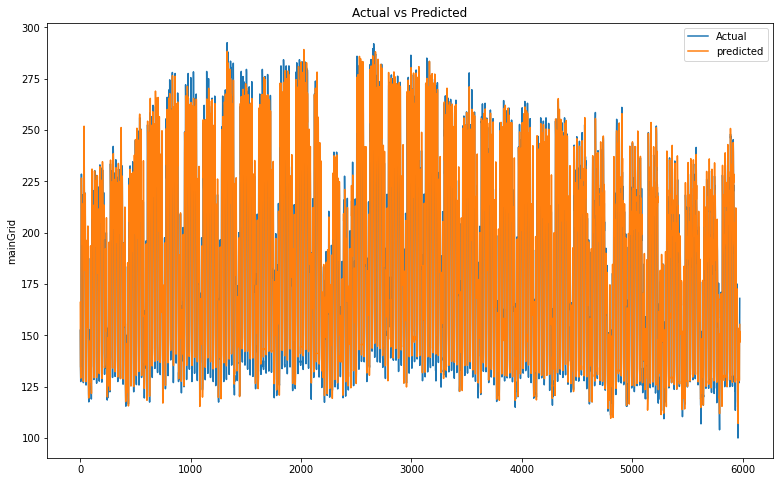

In [21]:
def predict_sample(x):
  with tf.GradientTape() as tape:
    weights_pred = hypernet(x)

    set_parameters(weights_pred)
    preds = lstm_model(x)

  return preds


def predict(dataset):
  predictions = []  
  for step, (x, y) in enumerate(tqdm(dataset, desc='Testing')):
      pred = predict_sample(x)
      predictions.append(float(pred))

  return np.array(predictions)


test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(1)


def evaluate(pred, y):

  #rescale 
  #pred_rescaled = (pred + min_value) * (max_value - min_value)
  #y_rescaled = (y + min_value) * (max_value - min_value)


  return float(loss_fn1(y, pred)), float(loss_fn2(y, pred))


pred_test = predict(test_dataset)

timeseries_evaluation_metrics_func(y_test, pred_test)

plotActualVsPred(y_test, pred_test)

Testing:   0%|          | 0/5986 [00:00<?, ?it/s]

Evaluation metric results: 
MSE is : 2151.672645543294
MAE is : 40.31393238887156
RMSE is : 46.386125571589766
R2 is : -0.04848439800903348



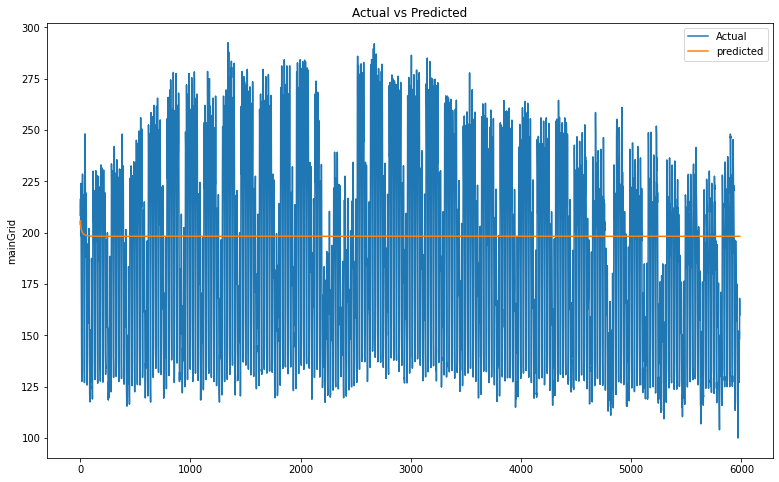

In [10]:
def predict_sample(x):
  with tf.GradientTape() as tape:
    weights_pred = hypernet(x.reshape(1, 1, look_back))
    set_parameters(weights_pred)
    preds = lstm_model(x.reshape(1, 1, look_back))

  return preds


def predict(sample, size_of_dataset):
  predictions = []  
  for step in enumerate(tqdm(range(size_of_dataset), desc='Testing')):
      pred = predict_sample(sample)
      predictions.append(float(pred))
      sample[:look_back - 2] = sample[1:look_back - 1]
      sample[look_back-1] = float(pred)

  return np.array(predictions)


def evaluate(pred, y):

  #rescale 
  #pred_rescaled = (pred + min_value) * (max_value - min_value)
  #y_rescaled = (y + min_value) * (max_value - min_value)


  return float(loss_fn1(y, pred)), float(loss_fn2(y, pred))



last_sample = np.array(list(train_data)[-look_back:])
pred_test = predict(last_sample, num_test)

timeseries_evaluation_metrics_func(test_data.to_numpy(), pred_test)

plotActualVsPred(test_data.to_numpy(), pred_test)

In [22]:
hypernet.save('hypernet_10')
!zip -r hypernet_10.zip hypernet_10

  adding: hypernet_10/ (stored 0%)
  adding: hypernet_10/assets/ (stored 0%)
  adding: hypernet_10/variables/ (stored 0%)
  adding: hypernet_10/variables/variables.index (deflated 46%)
  adding: hypernet_10/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: hypernet_10/keras_metadata.pb (deflated 88%)
  adding: hypernet_10/saved_model.pb (deflated 89%)


In [14]:
#!unzip hypernet_w5.zip
hypernet = tf.keras.models.load_model('hypernet_w5')

hypernet.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 1, 256)            1536      
                                                                 
 dense_28 (Dense)            (None, 1, 256)            65792     
                                                                 
 dense_29 (Dense)            (None, 1, 3009)           773313    
                                                                 
Total params: 840,641
Trainable params: 840,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plt.plt